In [1]:
import logging


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

In [2]:
from src.datasets.mnist_dataset import MiniMNIST32x32Dataset
from src.experiment1 import run_experiment1, LeNet5Builder
from src.models.compression.enums import Activation, NNParamsCompMode
from src.models.eval import NNArchitectureEvaluator
from src.models.nn import ActivationParams


params = LeNet5Builder().get_params(
    MiniMNIST32x32Dataset,
    conv_compression=NNParamsCompMode.NONE,
    conv_bitwidth=8,
    conv_activation=ActivationParams(Activation.BINARIZE_RESTE),
    fc_compression=NNParamsCompMode.BINARY,
    fc_bitwidth=8,
    fc_activation=ActivationParams(Activation.BINARIZE_RESTE),
)
evaluator = NNArchitectureEvaluator(params.train)
evaluator.evaluate_complexity(params)

666954.0

In [22]:

import pandas as pd

from src.experiment1 import run_on_dataset


# df = run_on_dataset(MiniMNIST32x32Dataset, 3, 1)
# df.to_csv("tmp.csv", index=False)
df = pd.read_csv("tmp.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   architecture      12 non-null     object 
 1   dataset           12 non-null     object 
 2   conv_compression  12 non-null     object 
 3   conv_activation   12 non-null     object 
 4   fc_compression    12 non-null     object 
 5   fc_activation     12 non-null     object 
 6   best              12 non-null     float64
 7   mean              12 non-null     float64
 8   accuracies        12 non-null     object 
 9   cost              12 non-null     float64
dtypes: float64(3), object(7)
memory usage: 1.1+ KB


,architecture,dataset,conv_compression,conv_activation,fc_compression,fc_activation,best,mean,accuracies,cost
0,LeNet5,MiniMNISTDataset,BINARY,NONE,BINARY,NONE,92.625,91.950,"[92.125, 91.75, 92.375, 90.875, 92.625]",33354.0
1,LeNet5,MiniMNISTDataset,NBITS,NONE,NBITS,NONE,90.250,88.175,"[84.5, 88.875, 90.25, 87.5, 89.75]",263682.0
2,LeNet5,MiniMNISTDataset,NONE,NONE,NONE,NONE,95.625,94.700,"[95.125, 94.25, 95.625, 93.125, 95.375]",1053378.0
3,LeNet5,MiniMNISTDataset,BINARY,BINARIZE,BINARY,BINARIZE,89.250,87.025,"[87.875, 85.875, 89.25, 85.875, 86.25]",53154.0
4,LeNet5,MiniMNISTDataset,NBITS,BINARIZE,NBITS,BINARIZE,72.125,68.975,"[68.625, 69.5, 72.125, 66.125, 68.5]",283482.0


In [23]:
relu_df = df.loc[df["conv_activation"] == "RELU"]
relu_df

,architecture,dataset,conv_compression,conv_activation,fc_compression,fc_activation,best,mean,accuracies,cost
9,LeNet5,MiniMNISTDataset,BINARY,RELU,BINARY,RELU,94.875,94.400,"[94.125, 94.5, 94.875, 93.875, 94.625]",251010.0
10,LeNet5,MiniMNISTDataset,NBITS,RELU,NBITS,RELU,90.375,85.500,"[84.875, 83.375, 90.375, 86.75, 82.125]",618930.0
11,LeNet5,MiniMNISTDataset,NONE,RELU,NONE,RELU,97.500,96.325,"[97.5, 94.875, 97.125, 96.0, 96.125]",1880370.0


In [24]:
import plotly.express as px

px.scatter(
    df,
    x="best",
    y="cost",
    color="conv_activation",
    symbol="conv_compression",
    title="Experiment 1: MiniMNIST32x32Dataset",
    labels={
        "conv_bitwidth": "Convolutional Layer Bitwidth",
        "fc_bitwidth": "Fully Connected Layer Bitwidth",
        "mean": "Accuracy (%)"
    }
).show()


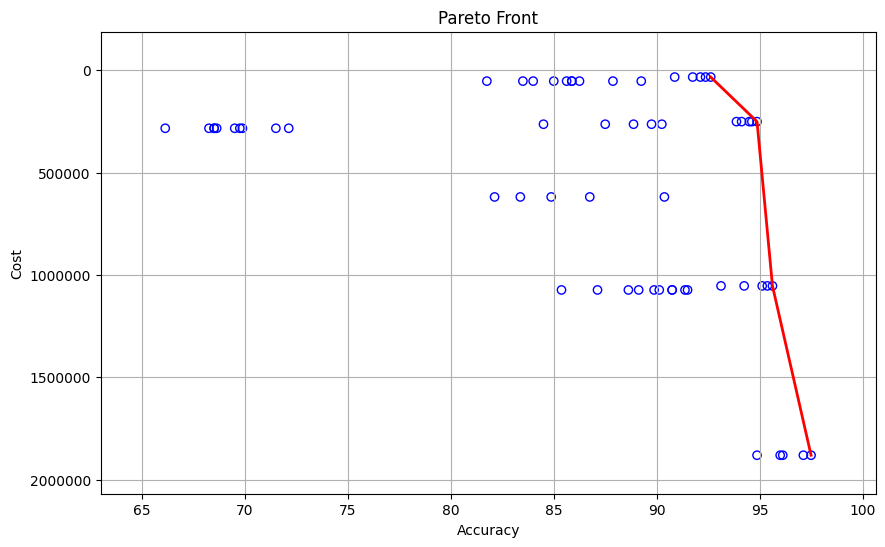

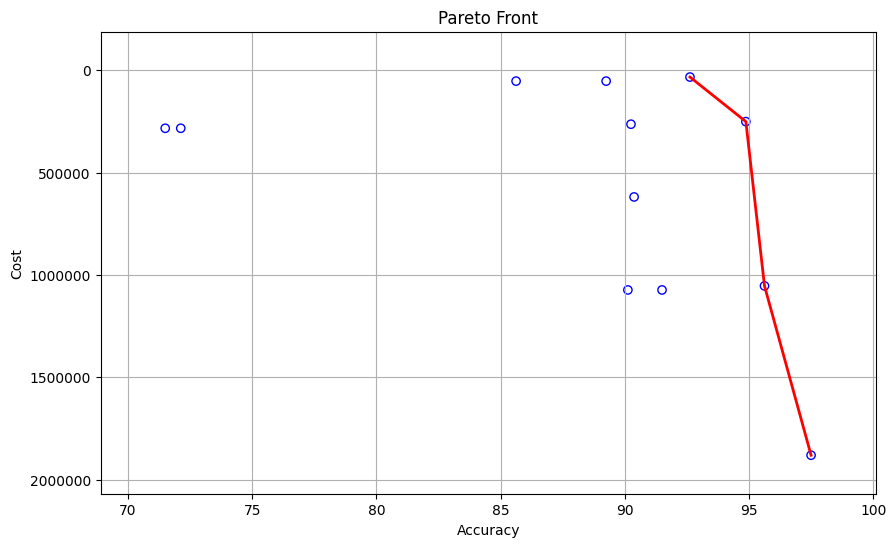

In [25]:
from matplotlib import pyplot as plt
import numpy as np

from src.nas.plot import plot_pareto_front


acc = []
cost = []
for _, row in df.iterrows():
    accuracies = row["accuracies"] if isinstance(row["accuracies"], list) else row["accuracies"].strip("[]").split(", ")
    for accuracy in accuracies:
        acc.append(float(accuracy))
        cost.append(row["cost"])

fig = plot_pareto_front(acc, cost)
fig = plot_pareto_front(df["best"], df["cost"])



In [35]:
import plotly.express as px

fig = px.scatter(
    df,
    x="best",
    y="cost",
    color="conv_compression",
    title="Best Accuracy vs Cost (MiniMNIST32x32Dataset)",
    hover_data=["conv_activation", "conv_compression"],
    labels={
        "cost": "Model Cost",
        "best": "Best Accuracy (%)",
        "conv_activation": "Conv Activation",
        "conv_compression": "Conv Compression"
    }
)
fig.update_yaxes(autorange="reversed")
fig.show()